In [1]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\musta\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
from keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import matplotlib.pyplot as plt

import numpy as np
from skimage import transform
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import splitfolders

In [3]:
splitfolders.ratio(
    "../Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.90,0.050, 0.050)
)

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )


Found 11200 images belonging to 4 classes.
Found 626 images belonging to 4 classes.
Found 620 images belonging to 4 classes.


In [3]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_dataset.image_shape))
model.add(MaxPool2D(2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))


model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [4]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [5]:
Info = model.fit(
                 train_dataset,
                 validation_data=valid_dataset,
                 epochs=5,
                 )

Epoch 1/5
112/112 [==============================] - 190s 2s/step - loss: 1.1235 - accuracy: 0.5763 - precision: 0.6653 - recall: 0.3862 - val_loss: 0.7679 - val_accuracy: 0.7048 - val_precision: 0.7676 - val_recall: 0.6500
Epoch 2/5
112/112 [==============================] - 221s 2s/step - loss: 0.6404 - accuracy: 0.7551 - precision: 0.7948 - recall: 0.7010 - val_loss: 0.3511 - val_accuracy: 0.8806 - val_precision: 0.8900 - val_recall: 0.8742
Epoch 3/5
112/112 [==============================] - 218s 2s/step - loss: 0.2459 - accuracy: 0.9233 - precision: 0.9300 - recall: 0.9140 - val_loss: 0.0271 - val_accuracy: 0.9984 - val_precision: 0.9984 - val_recall: 0.9984
Epoch 4/5
112/112 [==============================] - 191s 2s/step - loss: 0.1099 - accuracy: 0.9679 - precision: 0.9693 - recall: 0.9661 - val_loss: 0.0179 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919
Epoch 5/5
112/112 [==============================] - 188s 2s/step - loss: 0.0652 - accuracy: 0.9861 - pr

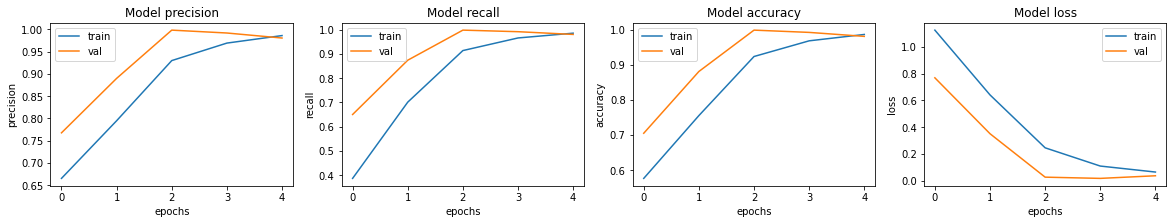

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(Info.history[met])
    ax[i].plot(Info.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [7]:
predictions = model.predict(test_dataset)

In [8]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [9]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(20,20))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.9840255591054313
Precision: 0.9821265808362767
Recall: 0.9723652574634342
F1_score: 0.9770675059944136


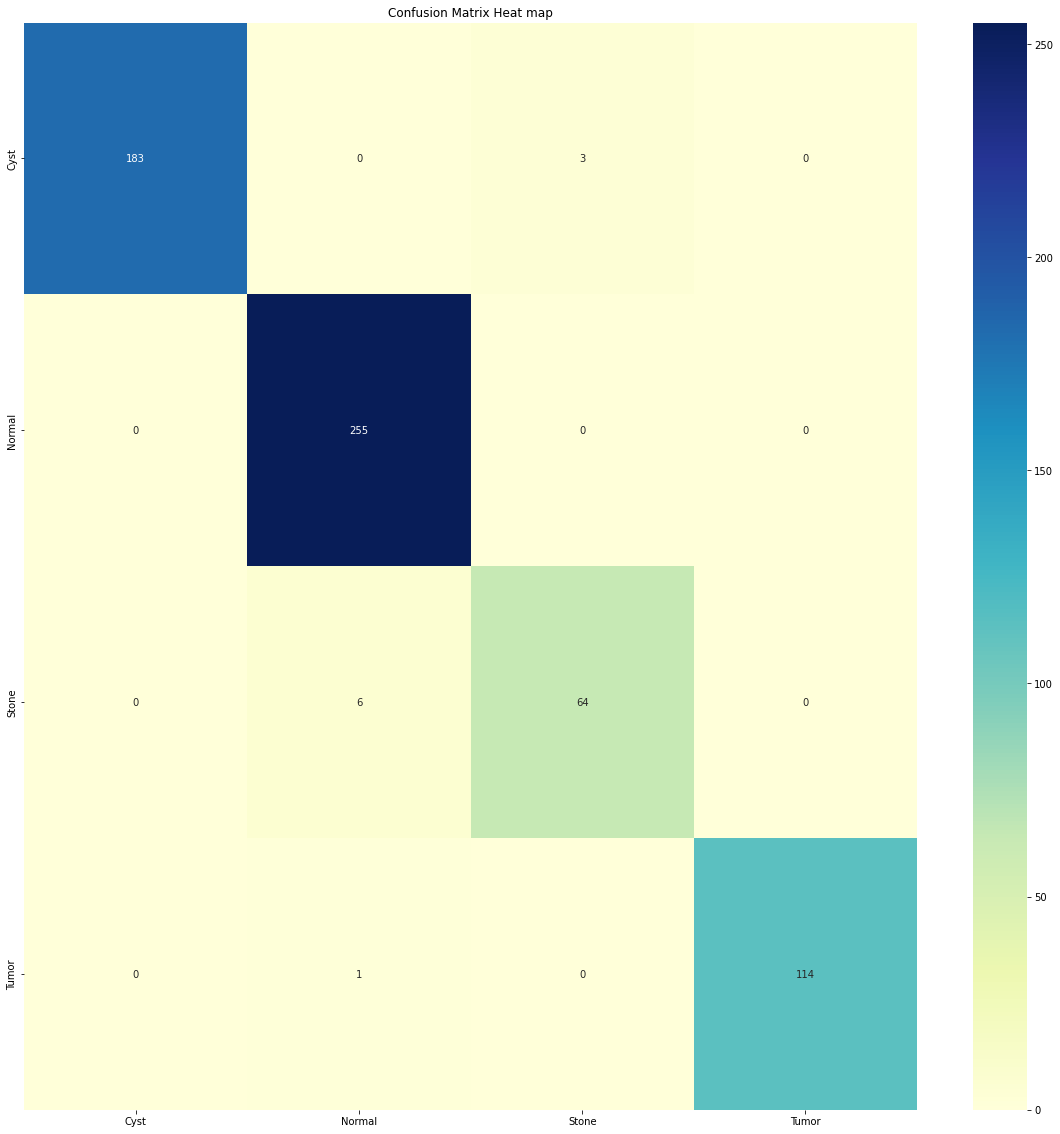

In [10]:
evaluate(test_dataset.classes,predictions)

In [12]:
model.evaluate(test_dataset)

7/7 [==============================] - 4s 487ms/step - loss: 0.0404 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840


[0.040441859513521194,
 0.9840255379676819,
 0.9840255379676819,
 0.9840255379676819]

In [13]:
model.save('cnn_model_kidney_diseases.h5')